# H2O-3 for Distributed ML

This notebook is intended to help you get started with distributed machine learning in the H2O AI Cloud using python.

* **Product Documentation:** https://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html
* **Python Documentation:** https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/index.html
* **Additional Tutorials:** https://github.com/h2oai/h2o-tutorials

In [1]:
import h2o_engine_manager

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
import h2o

import pandas as pd
import numpy as np

## Securely connect to the platform

In [ ]:
engine_manager = h2o_engine_manager.login()

## Connect to H2O-3
We will create and connect to a new H2O-3 engine. This step will connect our imported `h2o` library which we can then use to interact with the cluster. 

In [ ]:
h2o_engine = engine_manager.h2o_engine_client.create_engine(
    display_name="My test engine",
    version="latest"
)

h2o_engine.wait()

In [ ]:
h2o.connect(config=h2o_engine.get_connection_config())

## Data

We can create an H2O Dataframe object with data from our local machine or a URL. 

In [6]:
data = h2o.import_file("https://h2o-internal-release.s3-us-west-2.amazonaws.com/data/Splunk/churn.csv") 

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
data.shape

(3333, 21)

In [8]:
data.head()

State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10,3,2.7,1,False.
OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False.
NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,False.
OH,84,408,375-9999,yes,no,0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
AL,118,510,391-8027,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.7,0,False.
MA,121,510,355-9993,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False.
MO,147,415,329-9001,yes,no,0,157,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False.
LA,117,408,335-4719,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False.
WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,222,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False.


In [9]:
data.types

{'State': 'enum',
 'Account Length': 'int',
 'Area Code': 'int',
 'Phone': 'string',
 "Int'l Plan": 'enum',
 'VMail Plan': 'enum',
 'VMail Message': 'int',
 'Day Mins': 'real',
 'Day Calls': 'int',
 'Day Charge': 'real',
 'Eve Mins': 'real',
 'Eve Calls': 'int',
 'Eve Charge': 'real',
 'Night Mins': 'real',
 'Night Calls': 'int',
 'Night Charge': 'real',
 'Intl Mins': 'real',
 'Intl Calls': 'int',
 'Intl Charge': 'real',
 'CustServ Calls': 'int',
 'Churn?': 'enum'}

### Data Exploration

We can use H2O-3 to explore our dataset.  We can find correlations, build decision trees, and visualize our dataset.  In this demo, we will view the correlations and plot distributions.

We will first use H2O-3 to find the numeric columns that are correlated to Churn. 

In [10]:
numeric_cols = [k for k, v in data.types.items() if v in ['real', 'int']]
churn_cor_hf = data['Churn?'].cor(data[numeric_cols])
churn_cor_hf

Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0.0165407,0.00617423,-0.089728,0.205151,0.0184593,0.205151,0.0927958,0.00923313,0.092786,0.0354929,0.0061412,0.0354956,0.0682388,-0.0528443,0.0682586,0.20875


The result of the `cor` function is an H2O Frame with one row, showing the correlation of each variable to `Churn?`. Since this data is very small, we can convert it to a Pandas dataframe and order it based on absolute correlation.

In [11]:
churn_cor = churn_cor_hf.as_data_frame().transpose().reset_index()
churn_cor.columns = ['Feature', 'Correlation']
churn_cor = churn_cor.iloc[(-churn_cor['Correlation'].abs()).argsort()]
churn_cor.head()

,Feature,Correlation
15,CustServ Calls,0.208750
3,Day Mins,0.205151
5,Day Charge,0.205151
6,Eve Mins,0.092796
8,Eve Charge,0.092786


The greatest indicators of churn seem to be more calls to customer service as well as more calling minutes/charges.

We can use the histogram function to see the distribution of these top features.

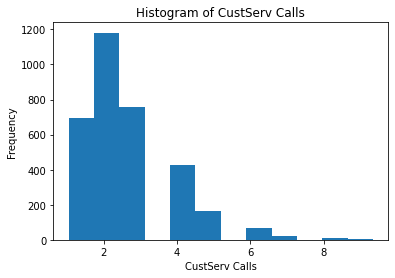

In [12]:
data['CustServ Calls'].hist();

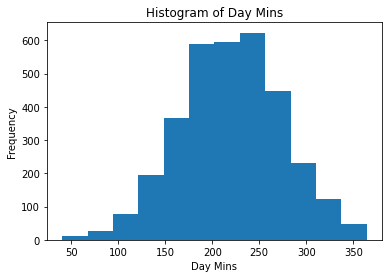

In [13]:
data['Day Mins'].hist();

### Split a Dataset

We will next split a dataset for training. When building models, we want to separate a section of data for validating how the model does.  This can be a good indicator of how well the model is at generalizing and predicting on unseen data.

We will use the split function to create a random split on the dataset.

In [14]:
splits = data.split_frame(ratios=[0.7, 0.15], seed=1)  

train = splits[0]
valid = splits[1]
test = splits[2]

### Prepare columns for training

In [15]:
y = 'Churn?'
x = [i for i in data.columns if i not in [y, 'Phone']] # remove columns

## Modeling

In this section, we will create models predicting Churn using H2O-3's algorithms.

### Baseline Model

We will start our modeling by building a baseline model.  This is a simple model that we will use as a control. In this example, we will build a Linear model to predict churn.

We first create an object of class, "H2OGeneralizedLinearEstimator". This does not actually do any training, it just sets the model up for training by specifying model parameters.

In [16]:
glm_fit1 = H2OGeneralizedLinearEstimator(model_id='glm_fit1',
                                         ## fix a random number generator seed for reproducibility
                                         seed=1234,
                                         
                                         ## predict a yes/no column
                                         family='binomial',
                                         
                                         ## cross validation
                                         nfolds=3, 
                                         
                                         ## use cross validation to find the best regularization
                                         lambda_search=True 
                                        )

Now that `glm_fit1` object is initialized, we can train the model:

In [17]:
glm_fit1.train(x = x, y = y, training_frame = train, validation_frame = valid);

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


The plot below shows the objective loss function as each iteration of the model is trained.

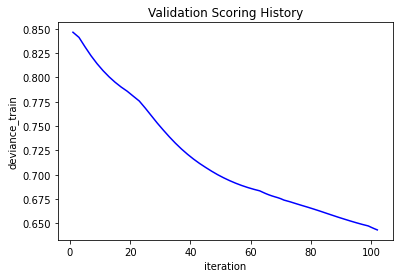

In [18]:
glm_fit1.plot();

#### Explore predictions

Let's see the performance of the GLM that were just trained. 

In [19]:
glm_perf1 = glm_fit1.model_performance(test)

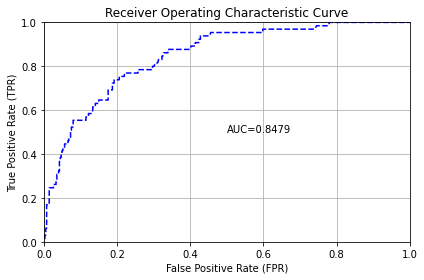

In [20]:
glm_perf1.plot();

We can see the AUC on the training dataset compared with the validation dataset.  The linear model is slighly better at predicting on the training dataset.  This is to be expected since the training data was seen by the model.

In [21]:
print ("AUC on Training Data: {0:.3f}".format(glm_fit1.auc(train = True)))
print ("AUC on Validation Data: {0:.3f}".format(glm_fit1.auc(valid = True)))

AUC on Training Data: 0.834
AUC on Validation Data: 0.817


Here are the predictions on the validation dataset.

In [22]:
glm_preds = glm_fit1.predict(valid)
glm_preds.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,False.,True.
False.,0.87653,0.12347
True.,0.486393,0.513607
False.,0.71364,0.28636
False.,0.858283,0.141717
False.,0.970588,0.0294123
False.,0.944882,0.0551175
False.,0.862908,0.137092
False.,0.961935,0.0380645
False.,0.922746,0.0772542
False.,0.968175,0.0318246


Since our model is a GLM model, we can also see the coefficients of each variable. The plot below shows that `Int'l Plan=Yes` increases the likelihood of churn.

In [ ]:
glm_fit1.std_coef_plot(num_of_features=5)

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


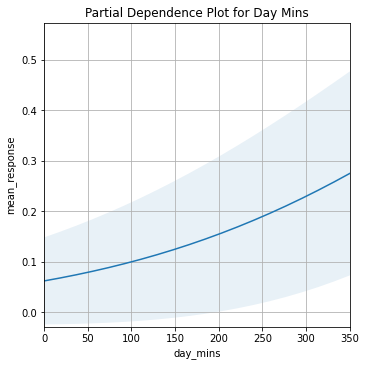

In [26]:
glm_fit1.partial_plot(data=train, cols=['Day Mins'], figsize=(5, 5));

### AutoML

We will now automate the machine learning process using AutoML and the `explain` function.  AutoML will automatically tune models and try out different algorithms for the user and provide a leaderboard. 

In [27]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(## train up to 10 models
                max_models=10, 
    
                ## set seed for reproducibility
                seed=1234,
                
                ## option to exclude specific algorithms
                exclude_algos=['StackedEnsemble', 'DeepLearning']
                )
aml.train(x=x, y=y, training_frame=train, leaderboard_frame=valid);

AutoML progress: |
00:39:30.975: AutoML: XGBoost is not available; skipping it.
00:39:31.55: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
00:39:31.55: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


The leaderboard belows shows us the AUC of each model on our `valid` data.  The best model is a Random Forest model.

In [28]:
aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_2_AutoML_1_20220706_03930,0.899849,0.183781,0.818355,0.143308,0.211693,0.044814
GBM_grid_1_AutoML_1_20220706_03930_model_2,0.895149,0.199008,0.80031,0.13447,0.22478,0.0505258
GBM_5_AutoML_1_20220706_03930,0.894465,0.185459,0.800027,0.148569,0.211678,0.0448074
DRF_1_AutoML_1_20220706_03930,0.887819,0.44122,0.837511,0.09375,0.217224,0.0471862
GBM_3_AutoML_1_20220706_03930,0.887276,0.18667,0.812002,0.135732,0.208377,0.0434209
GBM_grid_1_AutoML_1_20220706_03930_model_1,0.883838,0.178955,0.828886,0.118266,0.1988,0.0395214
XRT_1_AutoML_1_20220706_03930,0.879787,0.290344,0.807797,0.123422,0.237825,0.0565606
GBM_4_AutoML_1_20220706_03930,0.879577,0.19549,0.813502,0.131629,0.212793,0.0452811
GBM_1_AutoML_1_20220706_03930,0.873159,0.245236,0.713209,0.137311,0.257353,0.0662308
GLM_1_AutoML_1_20220706_03930,0.817796,0.309194,0.459268,0.261258,0.302586,0.0915581


In [29]:
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_1_20220706_03930


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,46.0,46.0,33715.0,7.0,7.0,7.0,27.0,59.0,42.565216




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.00867598318329953
RMSE: 0.09314495790594104
LogLoss: 0.04922249797381245
Mean Per-Class Error: 0.004763876199177707
AUC: 0.9999393273184102
AUCPR: 0.9996675130515511
Gini: 0.9998786546368204

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22615901479764813: 


,,False.,True.,Error,Rate
0,False.,1988.0,2.0,0.001,(2.0/1990.0)
1,True.,3.0,349.0,0.0085,(3.0/352.0)
2,Total,1991.0,351.0,0.0021,(5.0/2342.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.226159,0.992888,180.0
1,max f2,0.190623,0.992647,188.0
2,max f0point5,0.245942,0.995423,178.0
3,max accuracy,0.245942,0.997865,178.0
4,max precision,0.989105,1.000000,0.0
5,max recall,0.143025,1.000000,198.0
6,max specificity,0.989105,1.000000,0.0
7,max absolute_mcc,0.226159,0.991633,180.0
8,max min_per_class_accuracy,0.190623,0.995477,188.0
9,max mean_per_class_accuracy,0.190623,0.996318,188.0



Gains/Lift Table: Avg response rate: 15.03 %, avg score: 14.95 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010248,0.975916,6.653409,6.653409,1.000000,0.980852,1.000000,0.980852,0.068182,0.068182,565.340909,565.340909,0.068182
1,2,0.020068,0.966366,6.653409,6.653409,1.000000,0.970444,1.000000,0.975759,0.065341,0.133523,565.340909,565.340909,0.133523
2,3,0.030316,0.961086,6.653409,6.653409,1.000000,0.963300,1.000000,0.971547,0.068182,0.201705,565.340909,565.340909,0.201705
3,4,0.040137,0.955616,6.653409,6.653409,1.000000,0.958420,1.000000,0.968335,0.065341,0.267045,565.340909,565.340909,0.267045
4,5,0.050384,0.949942,6.653409,6.653409,1.000000,0.953596,1.000000,0.965338,0.068182,0.335227,565.340909,565.340909,0.335227
5,6,0.100342,0.889367,6.653409,6.653409,1.000000,0.924856,1.000000,0.945183,0.332386,0.667614,565.340909,565.340909,0.667614
6,7,0.150299,0.216799,6.482809,6.596704,0.974359,0.684568,0.991477,0.858558,0.323864,0.991477,548.280886,559.670390,0.989970
7,8,0.200256,0.065734,0.170600,4.993603,0.025641,0.109269,0.750533,0.671635,0.008523,1.000000,-82.939977,399.360341,0.941206
8,9,0.300171,0.035032,0.000000,3.331437,0.000000,0.046804,0.500711,0.463654,0.000000,1.000000,-100.000000,233.143670,0.823618
9,10,0.400085,0.024018,0.000000,2.499466,0.000000,0.028931,0.375667,0.355090,0.000000,1.000000,-100.000000,149.946638,0.706030




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.05539791243792369
RMSE: 0.23536761127632597
LogLoss: 0.21209361157716017
Mean Per-Class Error: 0.14041371630881683
AUC: 0.9063256624029238
AUCPR: 0.8111767352655737
Gini: 0.8126513248058476

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.273778010748177: 


,,False.,True.,Error,Rate
0,False.,1923.0,67.0,0.0337,(67.0/1990.0)
1,True.,87.0,265.0,0.2472,(87.0/352.0)
2,Total,2010.0,332.0,0.0658,(154.0/2342.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.273778,0.774854,195.0
1,max f2,0.171170,0.777840,222.0
2,max f0point5,0.541599,0.813070,133.0
3,max accuracy,0.293202,0.934244,188.0
4,max precision,0.991429,1.000000,0.0
5,max recall,0.003266,1.000000,397.0
6,max specificity,0.991429,1.000000,0.0
7,max absolute_mcc,0.273778,0.736824,195.0
8,max min_per_class_accuracy,0.062005,0.843750,289.0
9,max mean_per_class_accuracy,0.171170,0.869509,222.0



Gains/Lift Table: Avg response rate: 15.03 %, avg score: 12.72 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010248,0.955422,6.653409,6.653409,1.000000,0.970636,1.000000,0.970636,0.068182,0.068182,565.340909,565.340909,0.068182
1,2,0.020068,0.940095,6.364130,6.511847,0.956522,0.948753,0.978723,0.959927,0.062500,0.130682,536.413043,551.184720,0.130179
2,3,0.030316,0.925780,6.653409,6.559699,1.000000,0.933319,0.985915,0.950933,0.068182,0.198864,565.340909,555.969910,0.198361
3,4,0.040137,0.896228,6.653409,6.582628,1.000000,0.912015,0.989362,0.941410,0.065341,0.264205,565.340909,558.262814,0.263702
4,5,0.050384,0.868115,6.376184,6.540639,0.958333,0.882041,0.983051,0.929335,0.065341,0.329545,537.618371,554.063945,0.328540
5,6,0.100342,0.556494,5.345474,5.945600,0.803419,0.746239,0.893617,0.838177,0.267045,0.596591,434.547397,494.559961,0.584028
6,7,0.150299,0.233148,3.355138,5.084565,0.504274,0.368301,0.764205,0.681996,0.167614,0.764205,235.513792,408.456547,0.722496
7,8,0.200256,0.100612,1.137335,4.099862,0.170940,0.145543,0.616205,0.548169,0.056818,0.821023,13.733489,309.986189,0.730570
8,9,0.300171,0.044007,0.398067,2.867686,0.059829,0.064607,0.431010,0.387211,0.039773,0.860795,-60.193279,186.768557,0.659790
9,10,0.400085,0.027353,0.255900,2.215436,0.038462,0.034070,0.332978,0.299020,0.025568,0.886364,-74.409965,121.543611,0.572293




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.936386,0.008663,0.929638,0.927505,0.944444,0.933761,0.946581
1,auc,0.905572,0.012673,0.902022,0.888939,0.912904,0.901584,0.922408
2,err,0.063614,0.008663,0.070362,0.072495,0.055556,0.066239,0.053419
3,err_count,29.800000,4.086563,33.000000,34.000000,26.000000,31.000000,25.000000
4,f0point5,0.799785,0.034051,0.822622,0.758621,0.822785,0.766773,0.828125
5,f1,0.776282,0.036851,0.795031,0.721311,0.800000,0.755906,0.809160
6,f2,0.754312,0.040922,0.769231,0.687500,0.778443,0.745342,0.791045
7,lift_top_group,6.433440,0.772937,5.517647,5.684848,6.882353,7.200000,6.882353
8,logloss,0.215290,0.034978,0.257172,0.242893,0.192797,0.211387,0.172201
9,max_per_class_error,0.259563,0.043904,0.247059,0.333333,0.235294,0.261538,0.220588



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-07-06 00:40:12,7.601 sec,0.0,0.357364,0.423227,0.500000,0.150299,1.000000,0.849701
1,,2022-07-06 00:40:12,7.709 sec,5.0,0.262344,0.252827,0.977169,0.937010,6.653409,0.029035
2,,2022-07-06 00:40:13,7.800 sec,10.0,0.213610,0.188216,0.986771,0.957943,6.653409,0.025619
3,,2022-07-06 00:40:13,7.913 sec,15.0,0.183660,0.149481,0.992215,0.969919,6.653409,0.022630
4,,2022-07-06 00:40:13,8.023 sec,20.0,0.160428,0.120239,0.994861,0.979520,6.653409,0.020068
5,,2022-07-06 00:40:13,8.130 sec,25.0,0.143984,0.099934,0.997068,0.987085,6.653409,0.014944
6,,2022-07-06 00:40:13,8.300 sec,30.0,0.128760,0.081767,0.998196,0.991923,6.653409,0.010675
7,,2022-07-06 00:40:13,8.409 sec,35.0,0.117805,0.069675,0.998991,0.995165,6.653409,0.007686
8,,2022-07-06 00:40:13,8.519 sec,40.0,0.105686,0.058905,0.999643,0.998147,6.653409,0.005551
9,,2022-07-06 00:40:13,8.625 sec,45.0,0.096039,0.051241,0.999920,0.999557,6.653409,0.003416



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,State,261.457062,1.000000,0.216850
1,Day Mins,196.744736,0.752493,0.163178
2,CustServ Calls,154.550491,0.591112,0.128183
3,Day Charge,110.697166,0.423386,0.091811
4,Int'l Plan,86.897903,0.332360,0.072072
5,Intl Calls,79.236420,0.303057,0.065718
6,Eve Charge,61.366600,0.234710,0.050897
7,Intl Mins,53.108543,0.203125,0.044048
8,Eve Mins,50.958187,0.194901,0.042264
9,Intl Charge,38.061172,0.145573,0.031568


We can examine the model automatically by calling the explain function.  The explain function returns performance metrics, comparison between the models, and explains the best model.

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_2_AutoML_1_20220706_03930,0.899849,0.183781,0.818355,0.143308,0.211693,0.044814,1118,0.054919,GBM
GBM_grid_1_AutoML_1_20220706_03930_model_2,0.895149,0.199008,0.80031,0.13447,0.22478,0.0505258,840,0.059752,GBM
GBM_5_AutoML_1_20220706_03930,0.894465,0.185459,0.800027,0.148569,0.211678,0.0448074,572,0.043864,GBM
DRF_1_AutoML_1_20220706_03930,0.887819,0.44122,0.837511,0.09375,0.217224,0.0471862,1698,0.056871,DRF
GBM_3_AutoML_1_20220706_03930,0.887276,0.18667,0.812002,0.135732,0.208377,0.0434209,1298,0.091041,GBM
GBM_grid_1_AutoML_1_20220706_03930_model_1,0.883838,0.178955,0.828886,0.118266,0.1988,0.0395214,747,0.049364,GBM
XRT_1_AutoML_1_20220706_03930,0.879787,0.290344,0.807797,0.123422,0.237825,0.0565606,1140,0.056676,DRF
GBM_4_AutoML_1_20220706_03930,0.879577,0.19549,0.813502,0.131629,0.212793,0.0452811,1092,0.081414,GBM
GBM_1_AutoML_1_20220706_03930,0.873159,0.245236,0.713209,0.137311,0.257353,0.0662308,3525,0.065486,GBM
GLM_1_AutoML_1_20220706_03930,0.817796,0.309194,0.459268,0.261258,0.302586,0.0915581,1235,0.00937,GLM


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_2_AutoML_1_20220706_03930


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22615900593018554: 


,,False.,True.,Error,Rate
0,False.,1988.0,2.0,0.001,(2.0/1990.0)
1,True.,3.0,349.0,0.0085,(3.0/352.0)
2,Total,1991.0,351.0,0.0021,(5.0/2342.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

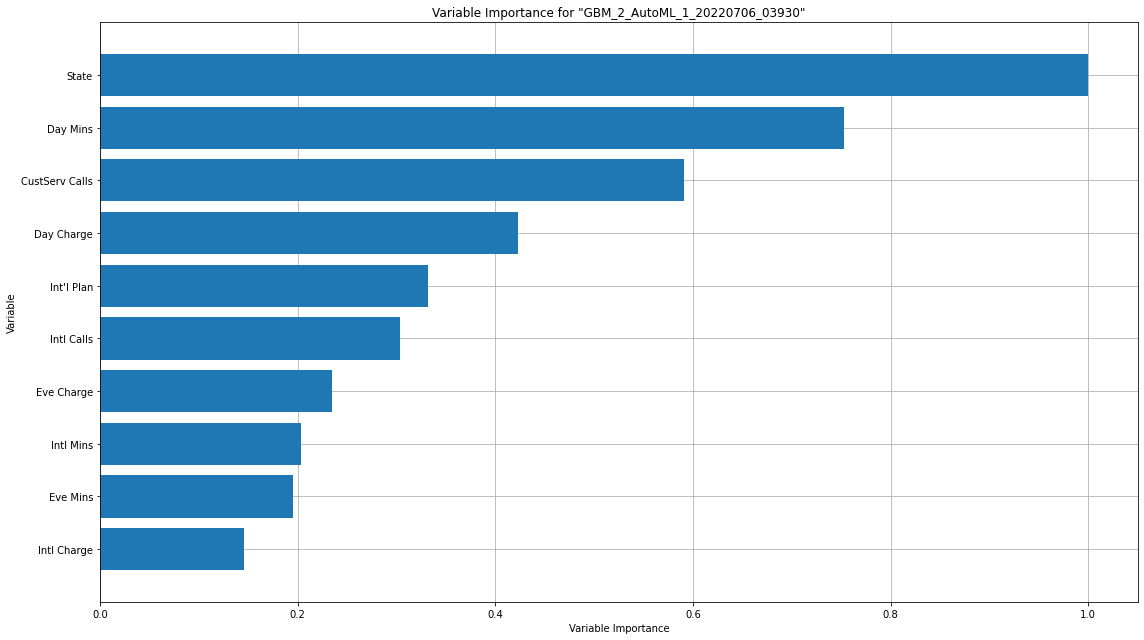

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

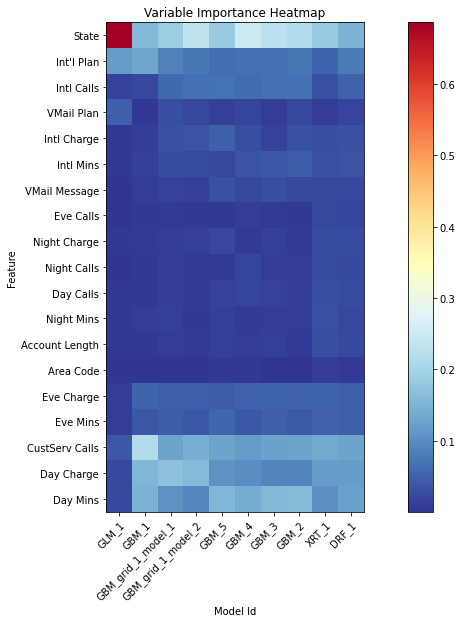

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

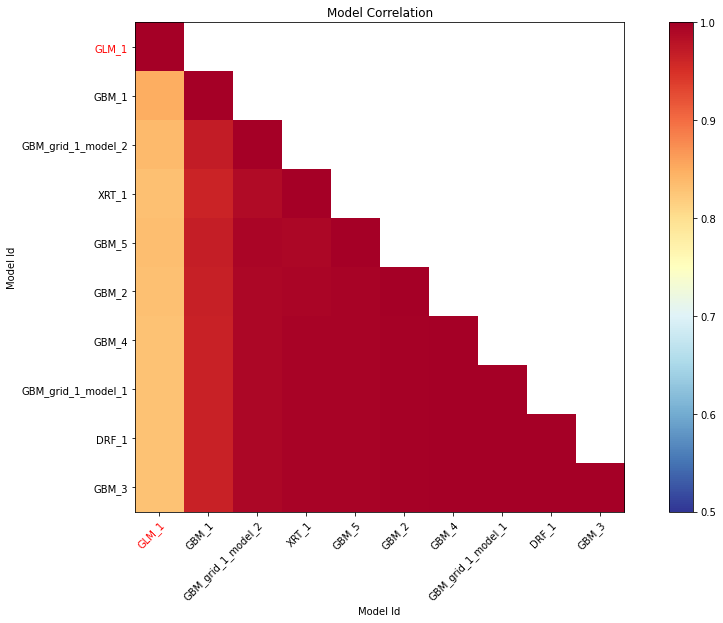

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

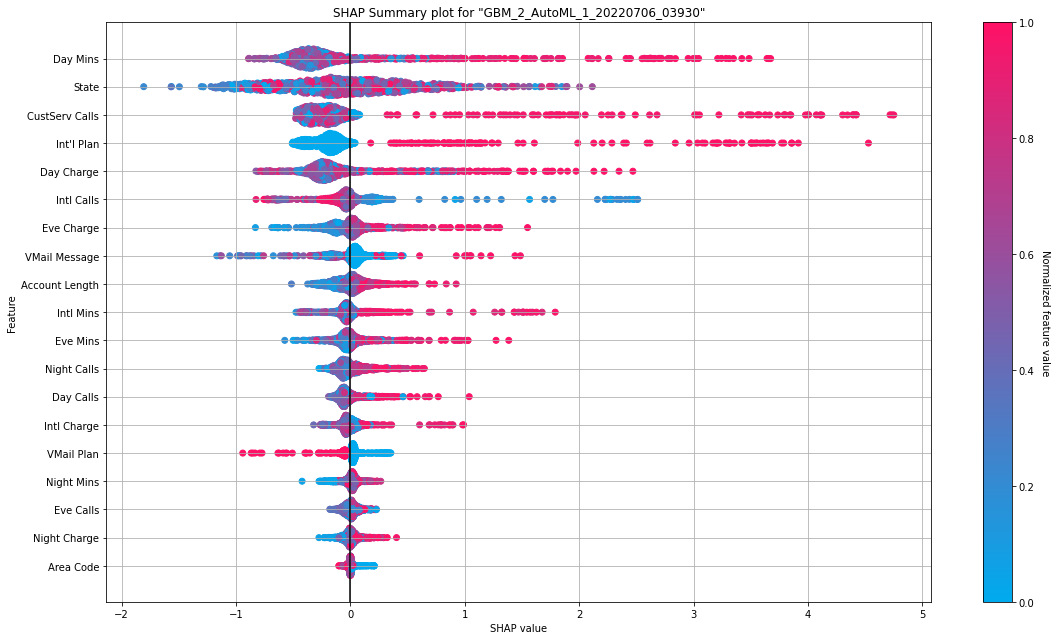

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

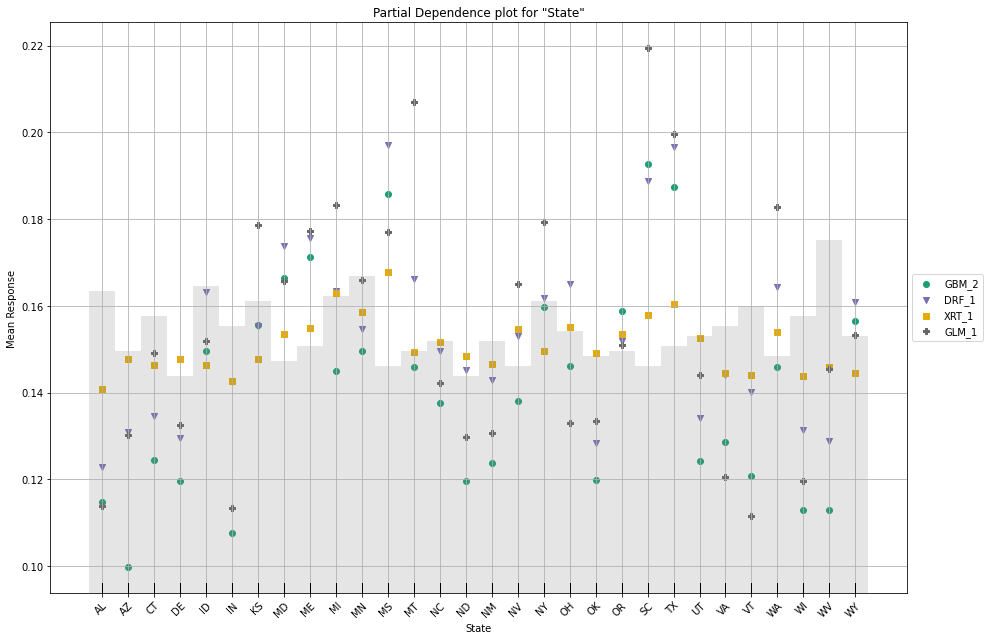

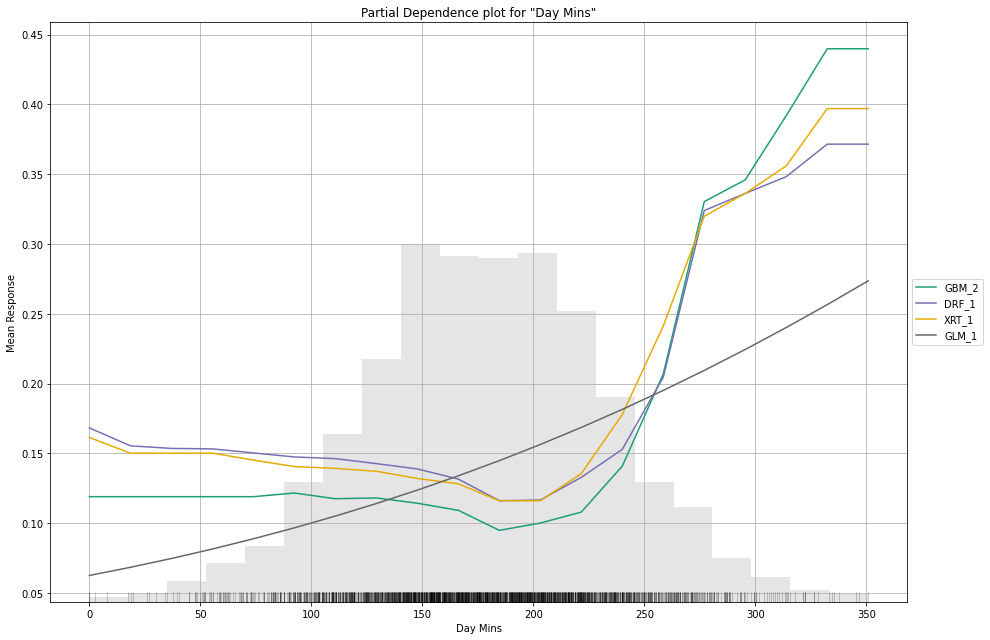

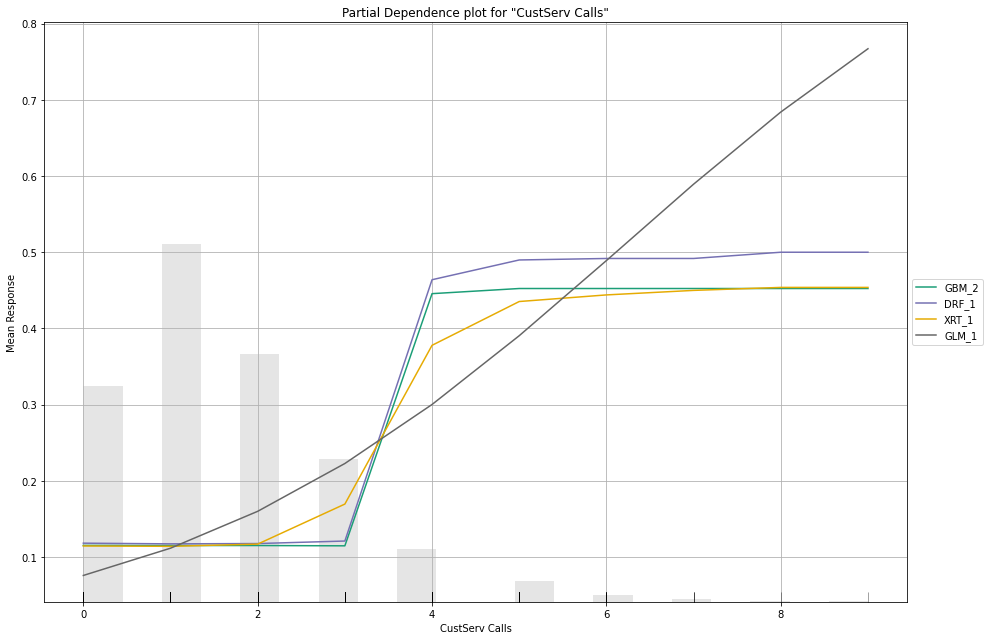

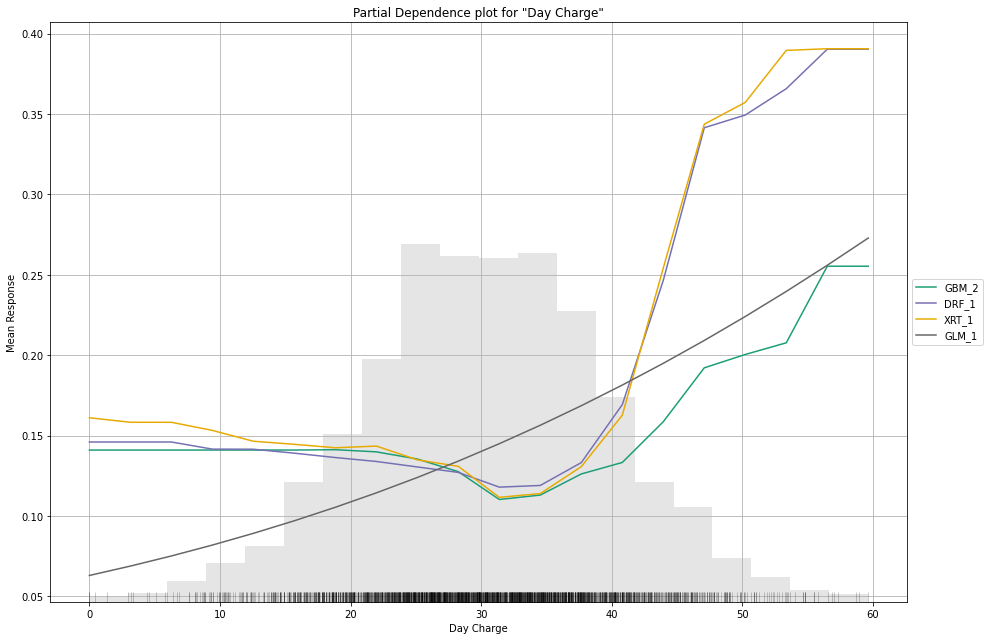

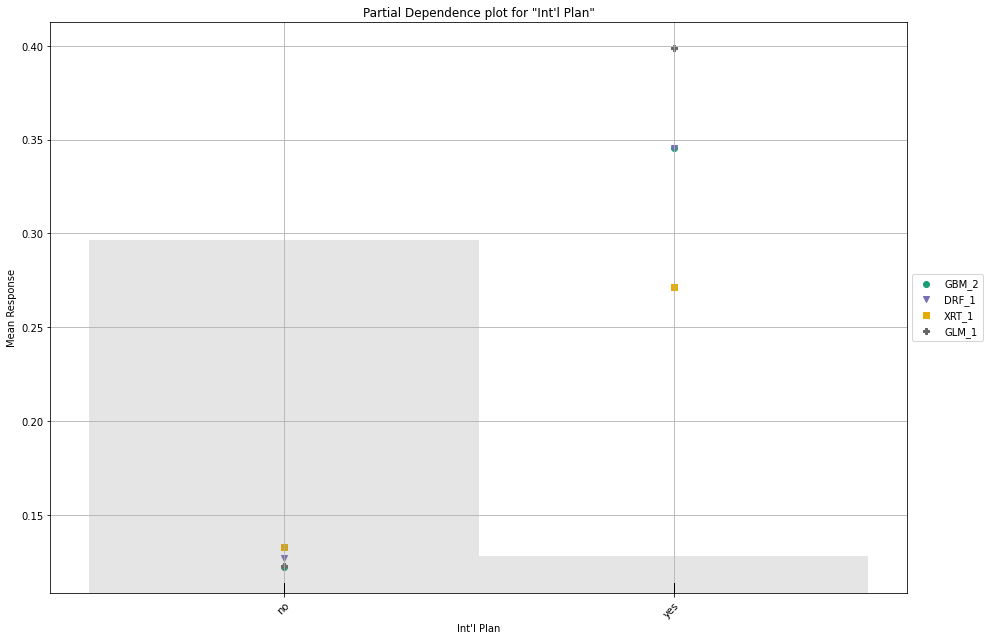

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_2_AutoML_1_20220706_03930,0.899849,0.183781,0.818355,0.143308,0.211693,0.044814,1118,0.054919,GBM
GBM_grid_1_AutoML_1_20220706_03930_model_2,0.895149,0.199008,0.80031,0.13447,0.22478,0.0505258,840,0.059752,GBM
GBM_5_AutoML_1_20220706_03930,0.894465,0.185459,0.800027,0.148569,0.211678,0.0448074,572,0.043864,GBM
DRF_1_AutoML_1_20220706_03930,0.887819,0.44122,0.837511,0.09375,0.217224,0.0471862,1698,0.056871,DRF
GBM_3_AutoML_1_20220706_03930,0.887276,0.18667,0.812002,0.135732,0.208377,0.0434209,1298,0.091041,GBM
GBM_grid_1_AutoML_1_20220706_03930_model_1,0.883838,0.178955,0.828886,0.118266,0.1988,0.0395214,747,0.049364,GBM
XRT_1_AutoML_1_20220706_03930,0.879787,0.290344,0.807797,0.123422,0.237825,0.0565606,1140,0.056676,DRF
GBM_4_AutoML_1_20220706_03930,0.879577,0.19549,0.813502,0.131629,0.212793,0.0452811,1092,0.081414,GBM
GBM_1_AutoML_1_20220706_03930,0.873159,0.245236,0.713209,0.137311,0.257353,0.0662308,3525,0.065486,GBM
GLM_1_AutoML_1_20220706_03930,0.817796,0.309194,0.459268,0.261258,0.302586,0.0915581,1235,0.00937,GLM


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_2_AutoML_1_20220706_03930


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22615900593018554: 


,,False.,True.,Error,Rate
0,False.,1988.0,2.0,0.001,(2.0/1990.0)
1,True.,3.0,349.0,0.0085,(3.0/352.0)
2,Total,1991.0,351.0,0.0021,(5.0/2342.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [30]:
aml.explain(train)

## Deployment objects

We can download the Model Deployment Object (the MOJO) for easy deployment in MLOps.

In [31]:
local_mojo = aml.leader.download_mojo()

## Clean up

In [ ]:
h2o_engine.delete()